# Spots classifier

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import numpy as np
import numpy.typing as npt

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

import matplotlib.pyplot as plt
import torch.nn.functional as func
from tqdm.notebook import tqdm
from PIL import Image
import gc
import torch.optim as optim
import pickle
import datetime 

import os,sys
try:
    import this_is_root
except:
    os.chdir(os.path.pardir) # change workdir to be root dir
    sys.path.insert(0, os.path.realpath("."))

import create_training_data.training_data_generator

torch.cuda.is_available()
np.random.seed(0)

c:\Users\talbarka.WISMAIN\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\talbarka.WISMAIN\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
imgs_generator = create_training_data.training_data_generator.ClassifierTrainingDataGenerator.make_default_training_data_generator(batch_size=1000)
TAG = 1
IMG = 0

In [4]:
val_generator = create_training_data.training_data_generator.ClassifierValidationDataGenerator()


In [5]:
val_data = val_generator.get_next_batch()
val_img = val_data[IMG]
val_label = val_data[TAG]

[1.0, 0.0, 1.0, 0.0]


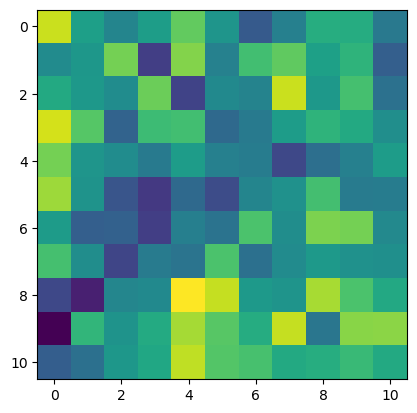

In [6]:
imgs= imgs_generator.get_next_batch()
idx = 36
print(imgs[TAG][idx])
plt.imshow(imgs[IMG][idx][:,:,1,1])

In [7]:
TEST_SIZE = 0.3
train_img, val_img, train_label, val_label = train_test_split(imgs[IMG], imgs[TAG], test_size=TEST_SIZE, random_state=0)

In [8]:
class MyDataset(Dataset):
    def __init__(self, img_array, label_array):
        # convert to tensor
        self.img_array   = img_array
        self.label_array = label_array

    def __len__(self):
        return len(self.label_array)

    def __getitem__(self, idx):
        img   = torch.tensor(self.img_array[idx].copy()).float()
        img = img.permute(3, 2, 1, 0)
        label = torch.tensor(self.label_array[idx])
        return img, label

val_ds = MyDataset(val_img, val_label)

In [9]:
train_ds = MyDataset(train_img, train_label)
# del train_img; del train_label
# gc.collect()

# val_ds   = MyDataset(val_img, val_label)
# del val_img; del val_label
# gc.collect()

In [10]:
train_label[10:15]

[[1.0, 0.0, 0.0, 1.0],
 [0.0, 0.0, 0.0, 0.0],
 [1.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0]]

In [11]:
# select only the first item in each list - 1 = spot, 0 = no spot
train_label = [lst[0] for lst in train_label]

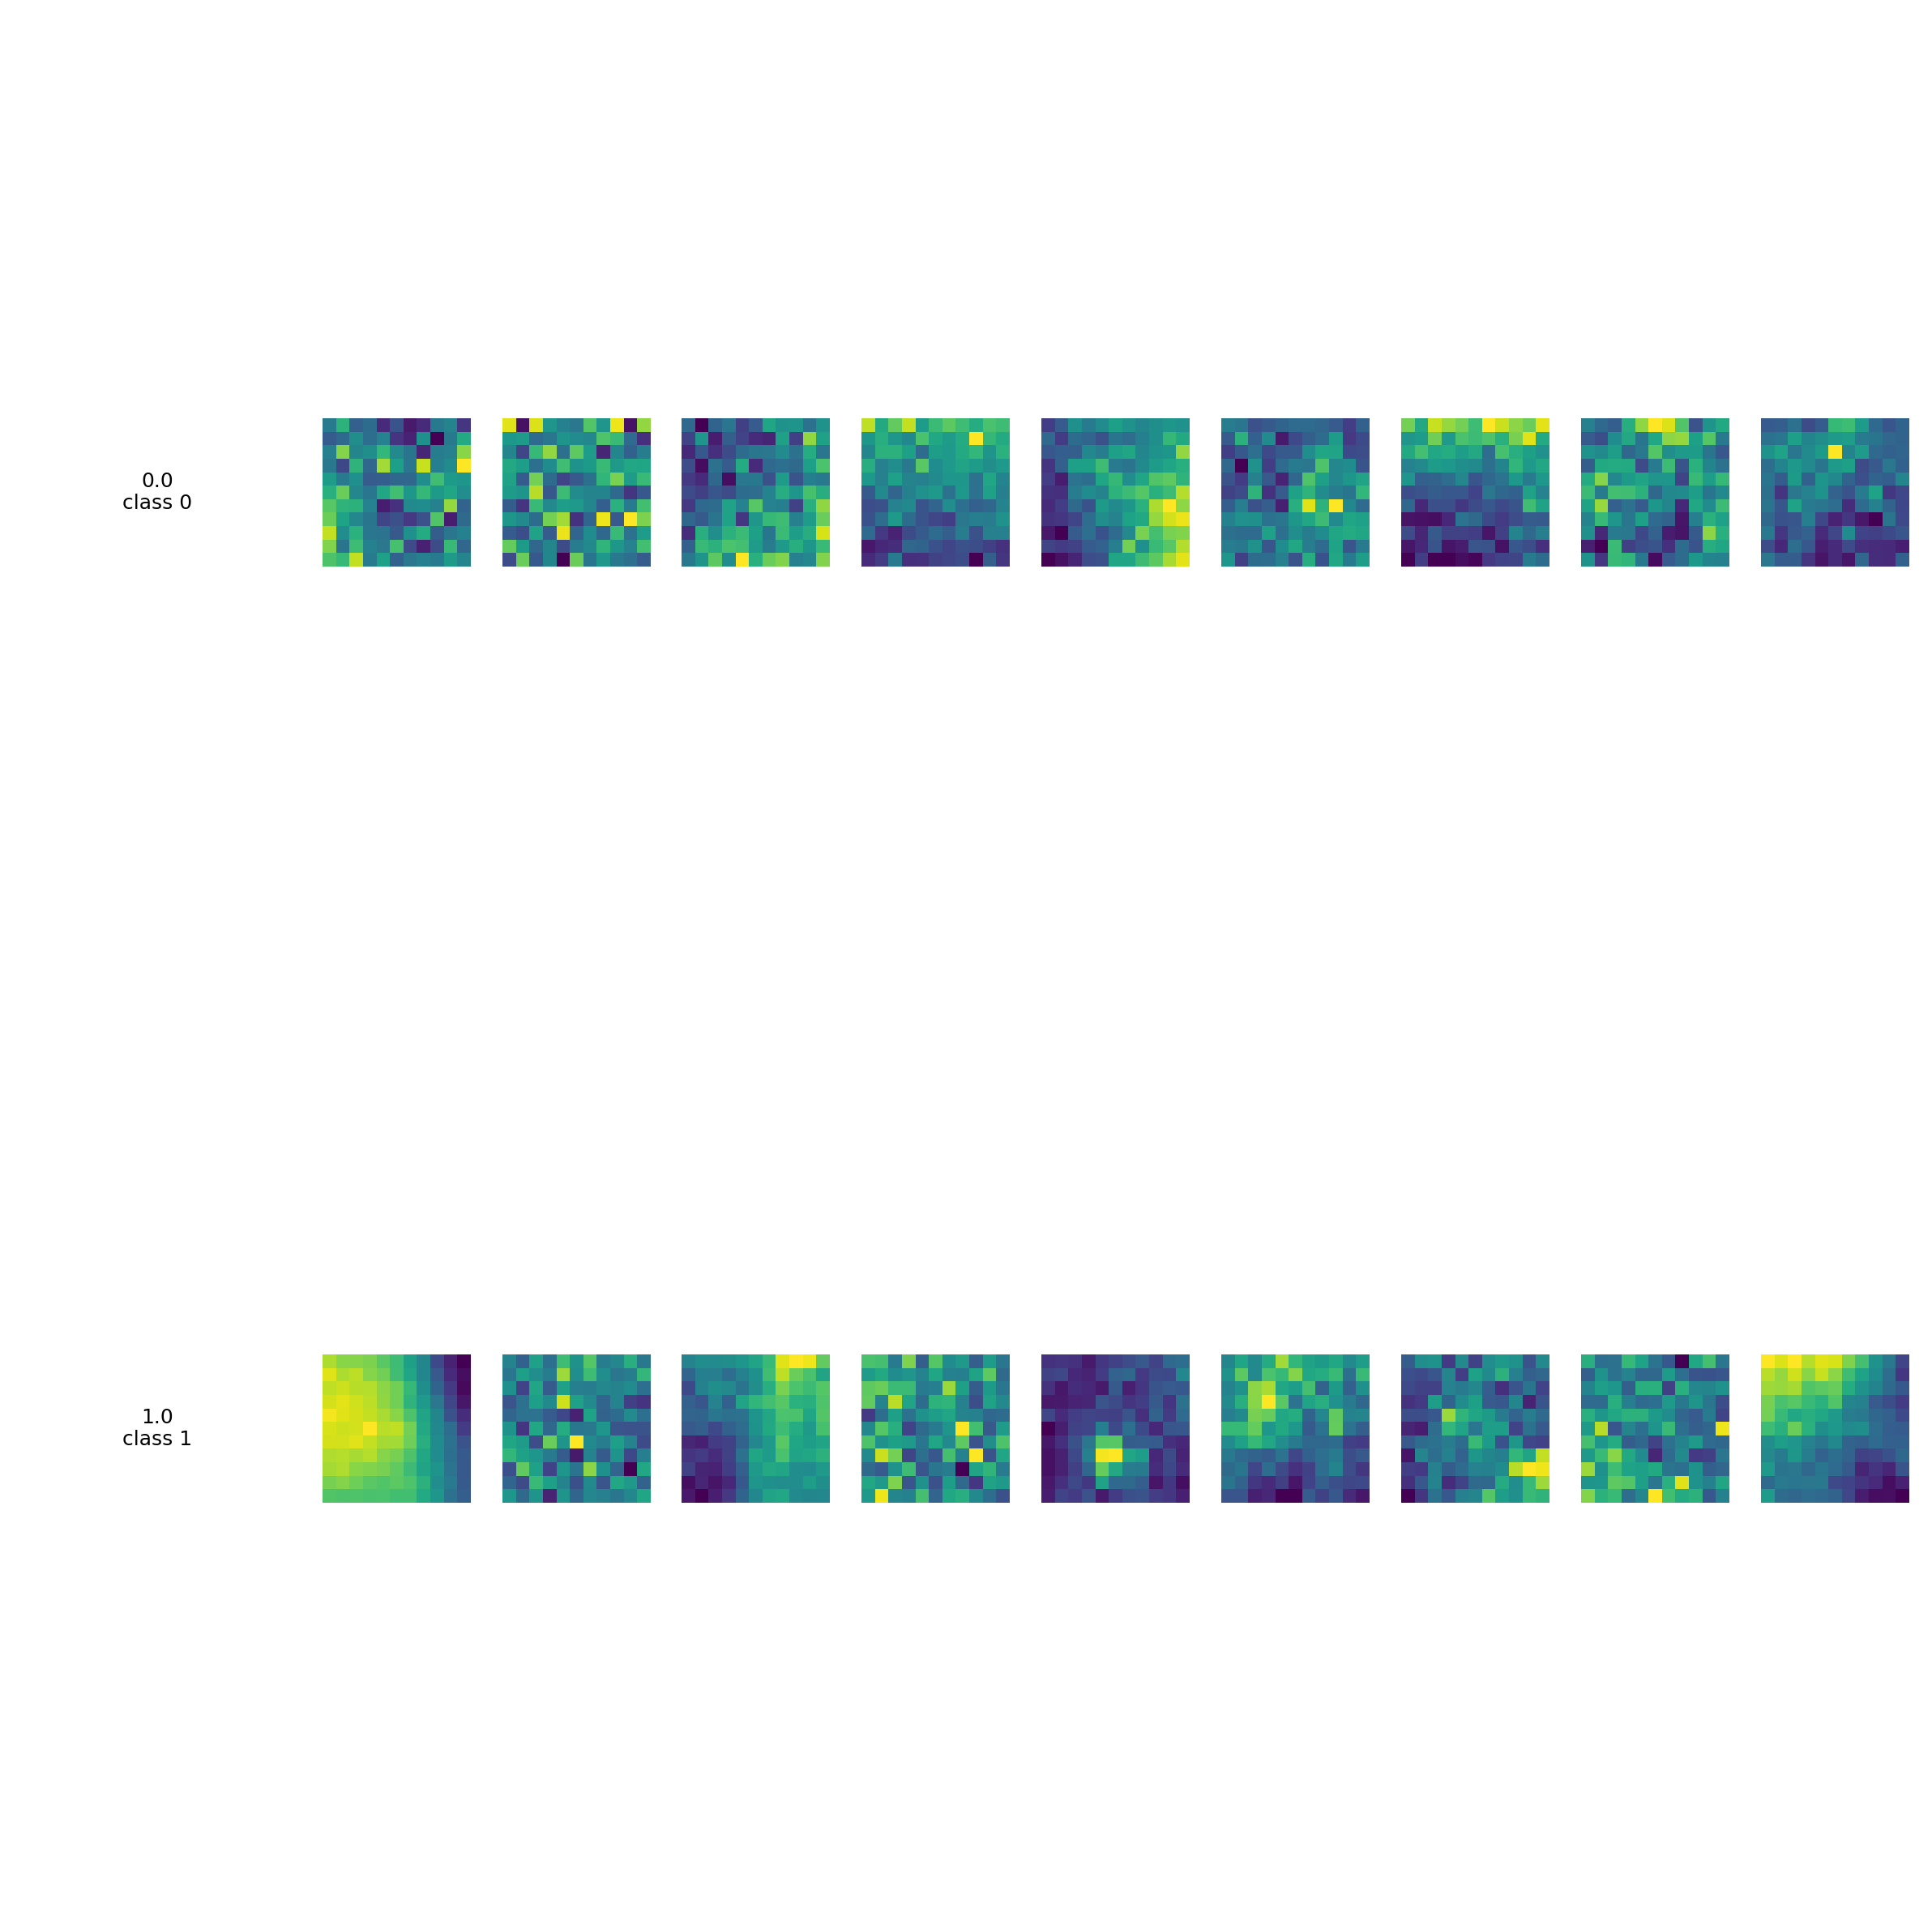

In [12]:
class_labels = np.unique(train_label)

fig = plt.figure(figsize=(10,10), dpi=300)

nrow, ncol = len(class_labels), 10
gs = GridSpec(nrow, ncol, hspace=0.0, width_ratios=[1.8,1,1,1,1,1,1,1,1,1])

for cl_idx, my_class in enumerate(class_labels):
    
    idxs = np.where(np.array(train_label)==my_class)[0]
    ax = fig.add_subplot(gs[cl_idx*ncol])

    center_x = (ax.get_xlim()[1] - ax.get_xlim()[0]) / 2
    center_y = (ax.get_ylim()[1] - ax.get_ylim()[0]) / 2

    ax.text(center_x, center_y, str(class_labels[cl_idx]) + f'\nclass {cl_idx}', ha='center', va='center', fontsize=6)
    ax.axis("off")

    for j in range(1, ncol):
        ax = fig.add_subplot(gs[cl_idx*ncol + j])
        ax.imshow(np.max(train_img[idxs[j-1]][:,:,:,np.max(int(my_class)-1,0)],axis=2))
        ax.axis("off")

### Import the CNN model

In [13]:
from model_classifier import spots_classifier_net

In [14]:
net = spots_classifier_net()

In [15]:
dl_batch_size = len(val_label)
# train_dl = DataLoader(train_ds, batch_size=dl_batch_size, shuffle=True)
valid_dl = DataLoader(val_ds, batch_size=dl_batch_size, shuffle=True)

### The training loop

In [21]:
def train_valid_loop(net, valid_dl, Nepochs, learning_rate=0.001, batch_size=100, save_model_interval=1500, epoch_report_interval=100, my_seed = 0,add_name_str=''):
    start_time = datetime.datetime.now()
    np.random.seed(my_seed)
    torch.manual_seed(my_seed)
    params_str = 'lr-'+str(learning_rate)+'_seed-'+str(my_seed)+add_name_str

    imgs_generator = create_training_data.training_data_generator.ClassifierTrainingDataGenerator.make_default_training_data_generator(batch_size=batch_size)
    TAG = 1
    IMG = 0
    imgs = imgs_generator.get_next_batch()
    train_img, train_label = imgs[IMG], imgs[TAG]

    train_ds = MyDataset(train_img, train_label)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    train_loss = []
    valid_loss = []
    epochs = []

    ### Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)# use Adam

    ### Check for GPU
    device = torch.device("cpu")
    if torch.cuda.is_available():
        print('Found GPU!')
        device = torch.device("cuda:0")

    net.to(device) # put it on the device

    pickle_output_filename = 'run_statistics_spot_detection_'+params_str+'.pickle'
    print("Pickle file: "+pickle_output_filename)
    # try:
    #     os.remove(pickle_output_filename)
    #     print(f"File '{pickle_output_filename}' deleted successfully.")
    # except FileNotFoundError:
    #     print(f"File '{pickle_output_filename}' not found.")
    
    for epoch in range(Nepochs):# loop over Nepochs
    # for epoch in tqdm(range(Nepochs)):# loop over Nepochs
        epochs.append(epoch)
        ### Training
        net.train()

        xb,yb = next(iter(train_dl))
        # select ony the first value of yb (dot/not dot), the rest of the values represent presence of spots in the channels
        yb = torch.tensor([lst[0] for lst in yb])

        xb = xb.to(device)
        yb = yb.to(device)
        
        optimizer.zero_grad() # make sure the gradients are zeroed-out each time!

        pred = net(xb) #pass the input through the net to get the prediction
        loss = func.cross_entropy(pred,yb) #use the MSE loss between the prediction and the target
        loss.backward()
        optimizer.step() #optimizer step in the direction of negative gradient

        ### take the average of the loss over each batch and append it to the list
        train_loss.append(loss.item())

        ### Validation
        net.eval()

        valid_loss_epoch = []
        for xb,yb in valid_dl:
            # edit yb again, but for the validation section
            yb = torch.tensor([lst[0] for lst in yb]) # select only the first element

            xb = xb.to(device)# move the validation input to the device
            yb = yb.to(device)# move the validation target to the device

            pred = net(xb)# same as in training loop
            loss = func.cross_entropy(pred,yb)# same as in training loop
            valid_loss_epoch.append(loss.item())

        valid_loss.append(np.mean(valid_loss_epoch))

        ### Model checkpointing
        if np.mod(epoch,save_model_interval) == 0 and epoch > 0:
            if valid_loss[-1] < min(valid_loss[:-1]):
                torch.save(net.state_dict(), 'final_saved_classifier_model_'+params_str+'.pt')
            with open(pickle_output_filename,"wb+") as f:
                pickle.dump({
                    "train_loss":train_loss,
                    "valid_loss":valid_loss,
                    "epoch":epochs,
                    "time":datetime.datetime.now() - start_time,
                    "learning_rate":learning_rate,
                    "seed":my_seed,
                    }, f)
        if np.mod(epoch,epoch_report_interval) == 0:
            print("Epoch: ",epoch,"(","{:.2f}".format(100*epoch/Nepochs),"%) Train loss: ",train_loss[-1]," Valid loss: ",valid_loss[-1])

    #Bring net back to CPU
    net.cpu()

    return train_loss, valid_loss

In [23]:
# single run
train_loss, valid_loss = train_valid_loop(net, valid_dl, batch_size=3000, Nepochs=201, learning_rate=1e-3, save_model_interval=200, my_seed=7,add_name_str='single')

Found GPU!
Pickle file: run_statistics_spot_detection_lr-0.001_seed-7single.pickle
Epoch:  0 ( 0.00 %) Train loss:  12009.5517578125  Valid loss:  844.1597900390625


In [20]:
# iterate on multiple learning rates and seeds
my_batch_size = 3000
for lr in tqdm([0.1,0.01]):
    for my_seed in [0,7]:
        train_loss, valid_loss = train_valid_loop(net, valid_dl, batch_size=my_batch_size, Nepochs=501, learning_rate=lr, save_model_interval=500, my_seed=my_seed)

  0%|          | 0/2 [00:00<?, ?it/s]

Found GPU!
Pickle file: run_statistics_spot_detection_lr-0.01_seed-0.pickle
Epoch:  0 ( 0.00 %) Train loss:  12009.55078125  Valid loss:  844.1597900390625
Epoch:  100 ( 19.96 %) Train loss:  12009.5517578125  Valid loss:  844.1598510742188
Epoch:  200 ( 39.92 %) Train loss:  12009.55078125  Valid loss:  844.1597900390625
Epoch:  300 ( 59.88 %) Train loss:  12009.55078125  Valid loss:  844.1597900390625
Epoch:  400 ( 79.84 %) Train loss:  12009.55078125  Valid loss:  844.1597900390625
Epoch:  500 ( 99.80 %) Train loss:  12009.55078125  Valid loss:  844.1598510742188
Found GPU!
Pickle file: run_statistics_spot_detection_lr-0.01_seed-7.pickle
Epoch:  0 ( 0.00 %) Train loss:  12009.5517578125  Valid loss:  844.1597900390625
Epoch:  100 ( 19.96 %) Train loss:  12009.55078125  Valid loss:  844.1597900390625
Epoch:  200 ( 39.92 %) Train loss:  12009.5517578125  Valid loss:  844.1597900390625
Epoch:  300 ( 59.88 %) Train loss:  12009.5517578125  Valid loss:  844.1597900390625
Epoch:  400 ( 79

### Load the best model from training

In [ ]:
net.load_state_dict(torch.load('saved_model.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

### Plot the training and validation losses

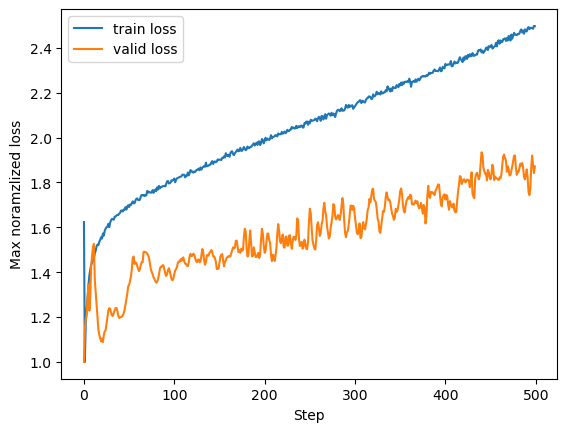

In [45]:
fig, axes = plt.subplots()
axes.plot(range(len(train_loss)),train_loss/np.max(train_loss),label='train loss')
axes.plot(range(len(valid_loss)),valid_loss/np.max(valid_loss),label='valid loss')
# axes.set_yscale('log')
axes.set_xlabel("Step")
axes.set_ylabel("Max noramzlized loss")
# axes.set_ylim([1e-2,1e0])
axes.legend()
plt.show()